# Introduction to mergeplg

mergeplg is a tool for processing rainfall data. It is used to **interpolate** rainfall measurements from commercial microwave links (CMLs) and rain gauges, and **merge** them with gridded radar data into a single dataset.

The tool works on two levels:
1. Low-level functions handle core interpolation methods like inverse distance weighting (IDW) and kriging.
2. High-level functions make workflows easier and faster by reusing weights wherever possible, such as across time steps in kriging or for extracting radar data along CML paths.

mergeplg also includes an experimental approach developed in collaboration with RADOLAN. This method is currently separate from the main high-level and low-level functions but is planned to be integrated into the high-level workflow in the future. 

In this introduction, we will work with both the high-level functions and the RADOLAN method.

mergeplg works with data formatted according to the OpenSense data format convention:  
https://github.com/OpenSenseAction/OS_data_format_conventions  

In this notebook, we use data from the OpenRainER dataset. For details on how this data was processed, check the notebook:  
`./data/OpenRainER_cmlProcessing.ipynb`

We will also use the poligrain package for plotting and calculating metrics:  
https://poligrain.readthedocs.io/en/latest/

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import poligrain as plg
import xarray as xr
import pandas as pd

from sklearn.model_selection import train_test_split


from mergeplg import interpolate, merge, radolan

## Load and transform data to OpenSense data format convention

### Load data

In [3]:
ds_gauges = xr.open_dataset("./data/openrainer_AWS.nc")
ds_cmls = xr.open_dataset("./data/openrainer_CML.nc")
ds_rad = xr.open_dataset("./data/openrainer_RAD.nc")

### Convert metadata

In [4]:
# Select one CML sublink
ds_cmls = ds_cmls.isel(sublink_id = 0)

# Rename metadata 
ds_gauges = ds_gauges.rename({"longitude": "lon", "latitude": "lat"})
ds_rad = ds_rad.rename({"lon": "x", "lat": "y"})
ds_rad = ds_rad.rename({"rainfall_amount": "rainfall_radar"}) # more explicit name
ys = [ds_rad.y.values,] * len(ds_rad.x.values)  
xs = [ds_rad.x.values,] * len(ds_rad.y.values) 
ds_rad["lat"] = (("y", "x"), np.array(ys).transpose())
ds_rad["lon"] = (("y", "x"), np.array(xs))
ds_rad = ds_rad.set_coords(["lon", "lat"])

### Project data 

In [5]:
# UTM32N: https://epsg.io/32632
ref_str = "EPSG:32632"

# Project gauge data
ds_gauges.coords["x"], ds_gauges.coords["y"] = plg.spatial.project_point_coordinates(
    ds_gauges.lon, ds_gauges.lat, ref_str
)

# For CML
(
    ds_cmls.coords["site_0_x"],
    ds_cmls.coords["site_0_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_0_lon, ds_cmls.site_0_lat, ref_str
)
(
    ds_cmls.coords["site_1_x"],
    ds_cmls.coords["site_1_y"],
) = plg.spatial.project_point_coordinates(
    ds_cmls.site_1_lon, ds_cmls.site_1_lat, ref_str
)

# Midpoint
ds_cmls.coords["x"] = (ds_cmls.site_0_x + ds_cmls.site_1_x) / 2
ds_cmls.coords["y"] = (ds_cmls.site_0_y + ds_cmls.site_1_y) / 2

# Projected radar coords
ds_rad.coords["x_grid"], ds_rad.coords["y_grid"] = (
    plg.spatial.project_point_coordinates(ds_rad.lon, ds_rad.lat, ref_str)
)

### Create test dataset

In [6]:
# Separate rain gauges for testing
ds_gauges_i, ds_gauges_test_i = train_test_split(np.arange(ds_gauges.id.size), test_size=0.33, random_state=42)
ds_gauges_test = ds_gauges.isel(id = ds_gauges_test_i)
ds_gauges = ds_gauges.isel(id = ds_gauges_i) # overwrite old dataset

## Interpolate ground observations

### Interpolate when no radar grid is available
Mergeplg requires a grid to be supplied. If no such grid is avaialble, for instance if you simply want to perform interpolation, a grid must be created. 

In [7]:
# Set size of gridcells
gridsize = 2000 # meters

# Create grid in meter using rain gauges
xmin = float(ds_gauges.x.min().astype(int))
xmax = float(ds_gauges.x.max().astype(int))
ymin = float(ds_gauges.y.min().astype(int))
ymax = float(ds_gauges.y.max().astype(int))
x_coords = np.arange(xmin, xmax + gridsize, gridsize)  
y_coords = np.arange(ymin, ymax + gridsize, gridsize)  
x_grid, y_grid = np.meshgrid(x_coords, y_coords)

# Create empty xarray.DataArray defining the  grid following the OpenSense 
# data format, note that the dimension order must be ('time', 'y', 'x').
da_grid = xr.DataArray(
    dims = ["time", "y", "x"], 
    coords=dict(
        x=x_coords,
        y=y_coords,
        x_grid=(["y", "x"], x_grid),
        y_grid=(["y", "x"], y_grid),
        time=ds_gauges.time,
    ),
)

In [8]:
# Perform interpolation using Ordinary Kriging. Mergeplg works by first 
# calcualting interpolation weights for all observations
interpolator = interpolate.InterpolateOrdinaryKriging(
    ds_grid=da_grid,
    ds_gauges=ds_gauges, # Specify that we use rain gauges
    variogram_parameters={"sill": 1, "range": 30000, "nugget": 0.3},
    variogram_model="spherical", 
    nnear=8, # Number of neighbors used for interpolation
    max_distance=20000, # max distance to perform interpolation 
    full_line=False, # If False, use midpoint of CMLs for interpolation
)

# The interpolation weights are reused for each time step
rainfall = []
for time in ds_gauges.time.data:
    rainfall.append(
        interpolator(
            da_gauges=ds_gauges.sel(time=time).rainfall_amount,
        )
    )

# Finally, store data in grid
da_grid.data = xr.concat(rainfall, dim="time")

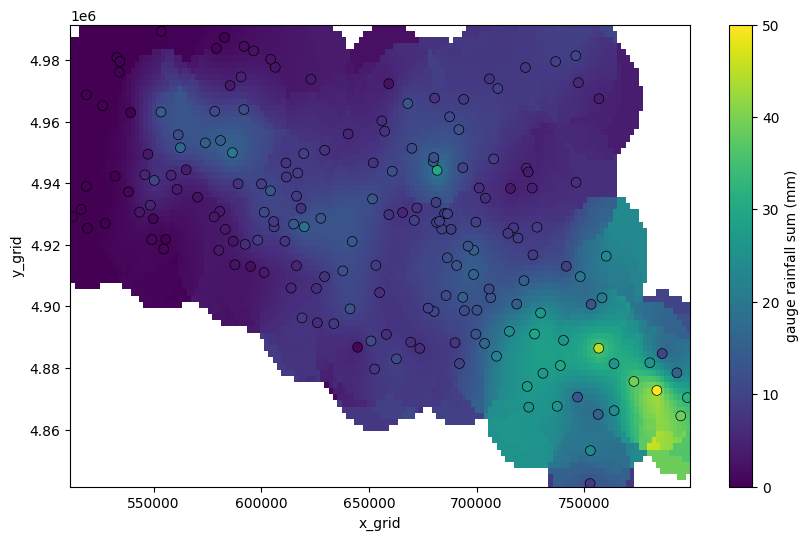

In [9]:
# Plot data using poligrain
fig, ax = plt.subplots(figsize=(10, 6))
plg.plot_map.plot_plg(
    da_grid=da_grid.sum(dim="time", skipna=False),
    da_gauges=ds_gauges.rainfall_amount.sum(dim="time"),
    use_lon_lat=False,
    vmin=0,
    vmax=50,
    cmap="viridis",
    marker_size=50,
    ax=ax,
    colorbar_label="gauge rainfall sum (mm)",
);

### Interpolate when radar grid is available
Often, a radar grid is avaialble, we can then perform interpolation like this

In [10]:
# Interpolate using IDW
interpolator = interpolate.InterpolateIDW(
    ds_grid=ds_rad.rainfall_radar, # Dimension order (time, y, x)
    ds_cmls=ds_cmls, # We can add CMLs to the interpolator
    ds_gauges=ds_gauges, # And gauges
    p = 2, # IDW interpolator parameter
    nnear=8, # 
    max_distance=20000, # max distance to perform interpolation 
)

rainfall = []
for time in ds_cmls.time.data:
    rainfall.append(
        interpolator(
            da_cmls=ds_cmls.sel(time=time).R,
            da_gauges=ds_gauges.sel(time=time).rainfall_amount,
        )
    )

# We can then store the interpolated field in the radar dataset
ds_rad["rainfall_interpolateIDW"] = xr.concat(rainfall, dim="time")

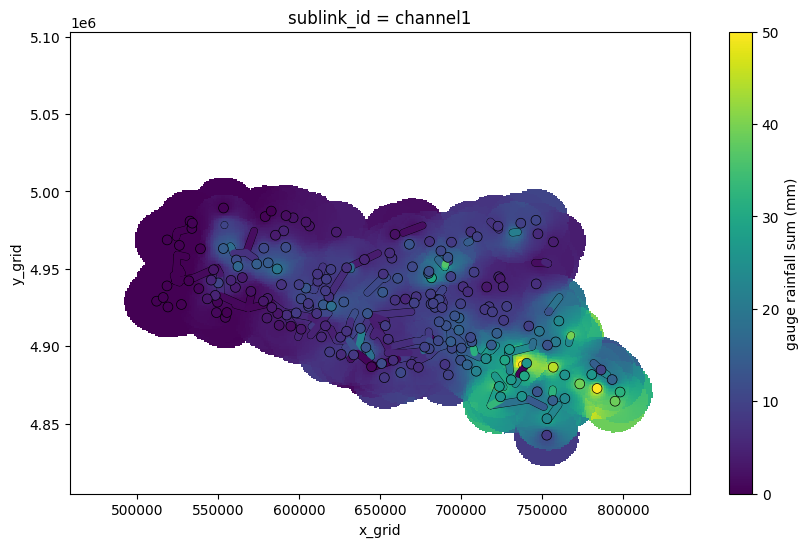

In [11]:
# Plot data using poligrain
fig, ax = plt.subplots(figsize=(10, 6))
plg.plot_map.plot_plg(
    da_grid=ds_rad.rainfall_interpolateIDW.sum(dim="time", skipna=False),
    da_gauges=ds_gauges.rainfall_amount.sum(dim="time"),
    da_cmls=ds_cmls.R.sum(dim="time"),
    use_lon_lat=False,
    vmin=0,
    vmax=50,
    cmap="viridis",
    marker_size=50,
    ax=ax,
    colorbar_label="gauge rainfall sum (mm)",
);

## Merge ground observations with radar data

### IDW additive

In [12]:
merger = merge.MergeDifferenceIDW(
    ds_rad=ds_rad.rainfall_radar, # Dimension order (time, y, x)
    ds_cmls=ds_cmls,
    # ds_gauges=ds_gauges, # uncomment to include rain gauges
    p=2, # IDW interpolator parameter
    nnear=8, # Number of nearby observations to use
    max_distance=60000, # Largest distance allowed for including an observation
    method="additive", # Additive/Multiplicative merging
    radar_threshold=0.01, # Radar values below this threshold are ignored when merging
    fill_radar=False, # If True, fills cells beyond max_distance with unadjusted radar 
    range_checks={'diff_check': 10, 'ratio_check': (0.1, 15)}, # Applies both diff and ratio checks
)

rainfall = []
for time in ds_cmls.time.data:
    rainfall.append(
        merger(
            da_rad=ds_rad.sel(time=time).rainfall_radar,
            da_cmls=ds_cmls.R.sel(time=time),
            # da_gauges=ds_gauges.sel(time=time).rainfall_amount, # uncomment to include rain gauges
        )
    )

# Store merged data together with radar data
ds_rad["rainfall_additiveIDW"] = xr.concat(rainfall, dim="time")

### Ordinary Kriging additive

In [13]:
merger = merge.MergeDifferenceOrdinaryKriging(
    ds_rad=ds_rad.rainfall_radar, # Dimension order (time, y, x)
    ds_cmls=ds_cmls,
    # ds_gauges=ds_gauges, # uncomment to include rain gauges
    variogram_model="spherical",
    variogram_parameters={"sill": 1, "range": 30000, "nugget": 0.3},
    method="additive", # Additive/Multiplicative merging
    nnear=8, # Number of nearby observations to use
    max_distance=60000, # Largest distance allowed for including an observation
    full_line=True, # USe the full line geometry in block kriging
    radar_threshold=0.01, # Radar values below this threshold are ignored when merging
    fill_radar=False, # If True, fills cells beyond max_distance with unadjusted radar 
    range_checks={'diff_check': 10, 'ratio_check': (0.1, 15)}, # Applies both diff and ratio checks
)

rainfall = []
for time in ds_cmls.time.data:
    rainfall.append(
        merger(
            da_rad=ds_rad.sel(time=time).rainfall_radar,
            da_cmls=ds_cmls.R.sel(time=time),
            # da_gauges=ds_gauges.sel(time=time).rainfall_amount, # uncomment to include rain gauges
        )
    )

# Store merged data together with radar data
ds_rad["rainfall_additiveBKline"] = xr.concat(rainfall, dim="time")

### Kriging with external drift

In [14]:
merger = merge.MergeKrigingExternalDrift(
    ds_rad=ds_rad.rainfall_radar, # Dimension order (time, y, x)
    ds_cmls=ds_cmls,
    # ds_gauges=ds_gauges, # uncomment to include rain gauges
    variogram_model="spherical",
    variogram_parameters={"sill": 1, "range": 30000, "nugget": 0.3},
    nnear=60, # KED tend to work better with larger neighborhood
    max_distance=60000, # Largest distance allowed for including an observation
    full_line=True,
    radar_threshold=0.01, # Radar values below this threshold are ignored when merging
    fill_radar=False, # If True, fills cells beyond max_distance with unadjusted radar 
    range_checks={'diff_check': 10, 'ratio_check': (0.1, 15)}, # Applies both diff and ratio checks
)

rainfall = []
for time in ds_cmls.time.data:
    rainfall.append(
        merger(
            ds_rad.sel(time=time).rainfall_radar,
            da_cmls=ds_cmls.sel(time=time).R,
            # da_gauges=ds_gauges.sel(time=time).rainfall_amount, # uncomment to include rain gauges
        )
    )
    
# Store merged data together with radar data
ds_rad["rainfall_KED"] = xr.concat(rainfall, dim="time")

## Plot merged fields 

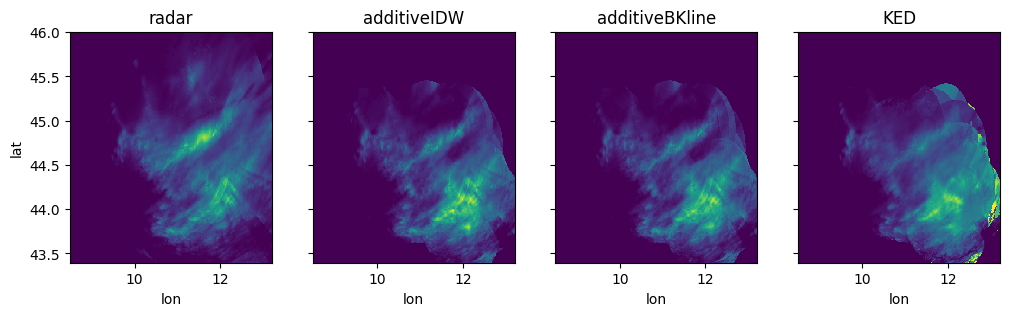

In [15]:
# Specify rainfall fields to plot
rainfall_fields = [
    "rainfall_radar",
    "rainfall_additiveIDW",
    "rainfall_additiveBKline",
    "rainfall_KED",
]

# Plot data using poligrain
fig, ax = plt.subplots(1, len(rainfall_fields), figsize=(len(rainfall_fields)*3, 3), sharex=True, sharey=True)
for i, rainfall_field in enumerate(rainfall_fields):
    plg.plot_map.plot_plg(
        da_grid=ds_rad[rainfall_field].sum(dim="time", skipna=True), # nan are filled with zeros
        use_lon_lat=True,
        vmin=0,
        vmax=50,
        cmap="viridis",
        ax=ax[i],
        add_colorbar=False
    );
    ax[i].set_title(rainfall_field.split("_")[1])
    if i != 0:
        ax[i].set_ylabel('')

## Compare merged fields with rain gauges

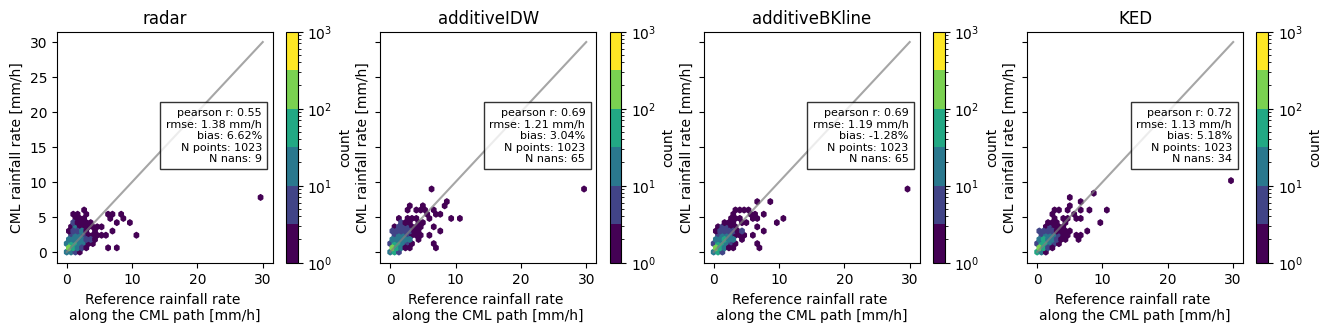

In [16]:
threshold = 0.1 # Values below this is ignored

# Specify rainfall fields to compare
rainfall_fields = [
    "rainfall_radar",
    "rainfall_additiveIDW",
    "rainfall_additiveBKline",
    "rainfall_KED",
]

# Get fields at validation rain gauges
get_grid_at_points = plg.spatial.GridAtPoints(
    da_gridded_data=ds_rad.rainfall_radar, # Coordinates for all rainfall fields
    da_point_data=ds_gauges_test, # Coordinates for test rain gauges
    nnear=1,
    stat="best",
)

# Sample rainfall fields
for rainfall_field in rainfall_fields:
    ds_gauges_test[rainfall_field] = get_grid_at_points(
        da_gridded_data=ds_rad[rainfall_field],
        da_point_data=ds_gauges_test.rainfall_amount, # 
    )

# Rain gauges from test dataset considered ground truth
ground_truth = ds_gauges_test.rainfall_amount.to_numpy().flatten()

# Plot metrics and scatterplots
fig, ax = plt.subplots(1, len(rainfall_fields), figsize=(len(rainfall_fields)*4, 3), sharex=True, sharey=True)
for i, rainfall_field in enumerate(rainfall_fields):
    # Get predictions at test gauges
    predicted = ds_gauges_test[rainfall_field].to_numpy().flatten()
    
    rainfall_metrics = plg.validation.calculate_rainfall_metrics(
        reference=ground_truth,
        estimate=predicted,
        ref_thresh=threshold,
        est_thresh=threshold,
    )
    
    # plotting the scatter density plots
    hx = plg.validation.plot_hexbin(
        ground_truth,
        predicted,
        ref_thresh=threshold,
        est_thresh=threshold,
        ax=ax[i],
    )
    ax[i].set_title(rainfall_field.split("_")[1])
    
    # adding metrics to the plot for subplot 0
    plotted_metrics = (
        f"pearson r: {np.round(rainfall_metrics['pearson_correlation_coefficient'], 2)}\n"
        f"rmse: {np.round(rainfall_metrics['root_mean_square_error'], 2)} mm/h\n"
        f"bias: {np.round(rainfall_metrics['percent_bias'], 2)}%\n"
        f"N points: {rainfall_metrics['N_all']}\n"
        f"N nans: {rainfall_metrics['N_nan']}"
    )
    
    ax[i].text(
        0.95,
        0.55,
        plotted_metrics,
        fontsize=8,
        transform=ax[i].transAxes,
        verticalalignment="center",
        horizontalalignment="right",
        bbox={"facecolor": "white", "alpha": 0.8},
    )


## Merge ground observations with radar data using RADOLAN method

### Convert metadata

In [23]:
# Rename metadata to comply with RADOLAN approach
ds_rad_radolan = ds_rad.copy()
ds_rad_radolan = ds_rad_radolan.rename({
    'x_grid': 'xs', 
    'y_grid': 'ys',
    'lat': 'latitudes',
    'lon': 'longitudes',
    'rainfall_radar': 'RH',
})
ds_rad_radolan['x'] = ds_rad_radolan.xs.isel(y = 0)
ds_rad_radolan['y'] = ds_rad_radolan.ys.isel(x = 0)
ds_rad_radolan['RH'] = ds_rad_radolan.RH.astype('float64')

# CML data to RADOLAN
ds_cml_radolan = ds_cmls.copy()
ds_cml_radolan['R'] = xr.where(ds_cml_radolan.R > 0, ds_cml_radolan.R, 0)

# ds_cml_radolan['R'] = ds_cml_radolan.R.fillna(0).astype("float64")

# CML data to dataframe
df_cml_radolan = radolan.io.transform_openmrg_data_for_old_radolan_code(ds_cml_radolan)
df_cml_radolan = df_cml_radolan.apply(lambda x: x.astype('float64') if x.dtype == 'float32' else x)


# Calculate intersection weights of CMLs 
intersection_weights = plg.spatial.calc_sparse_intersect_weights_for_several_cmls(
    x1_line=ds_cml_radolan.site_0_x.values, 
    y1_line=ds_cml_radolan.site_0_y.values,
    x2_line=ds_cml_radolan.site_1_x.values,
    y2_line=ds_cml_radolan.site_1_y.values,
    cml_id=ds_cml_radolan.cml_id.values,
    x_grid=ds_rad_radolan.xs.data,
    y_grid=ds_rad_radolan.ys.data,
    grid_point_location="lower_left",
)

### Merge
Loop through all time stamps and do adjustment

In [24]:
ds_radolan_t_list = []
df_stations_t_list = []
for t in ds_rad.time.data:
    ds_radolan_t, df_stations_t = radolan.processing.rh_to_rw(
        ds_radolan_t=ds_rad_radolan.sel(time=t),
        df_stations_t=df_cml_radolan.loc[t, :],
        allow_gauge_and_cml=True,
        intersect_weights=intersection_weights,
        max_distance=60000,
    )
    ds_radolan_t_list.append(ds_radolan_t)
    df_stations_t_list.append(df_stations_t)

ds_radolan = xr.concat(ds_radolan_t_list, dim="time")

# Convert coordinate names back and store in radar
ds_rad['rainfall_radolan'] = (('time', 'y', 'x'), ds_radolan['RW'].data)

### Plot merged fields

Text(0.5, 1.0, 'rainfall_radolan')

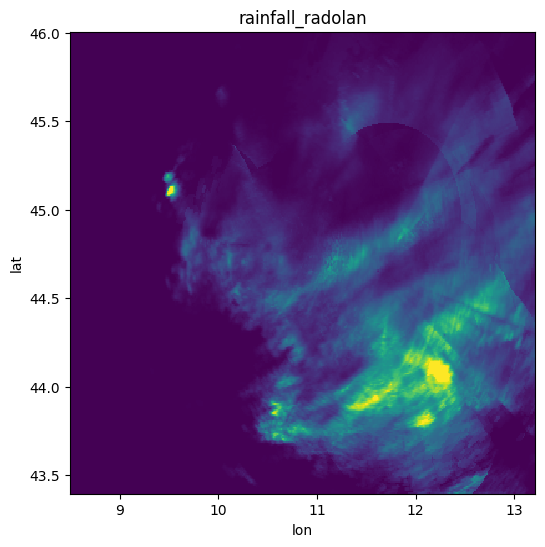

In [25]:
fig, ax = plt.subplots(figsize=(6, 6))
plg.plot_map.plot_plg(
    da_grid=ds_rad.rainfall_radolan.sum(dim="time", skipna=True),
    use_lon_lat=True,
    vmin=0,
    vmax=50,
    cmap="viridis",
    ax=ax,
    add_colorbar=False
);
ax.set_title('rainfall_radolan')


### Compare merged fields with rain gauges
NOTE: The RADOLAN approach use different preprocessing than what is performed in mergeplg, thus the results should not be compared directly. 

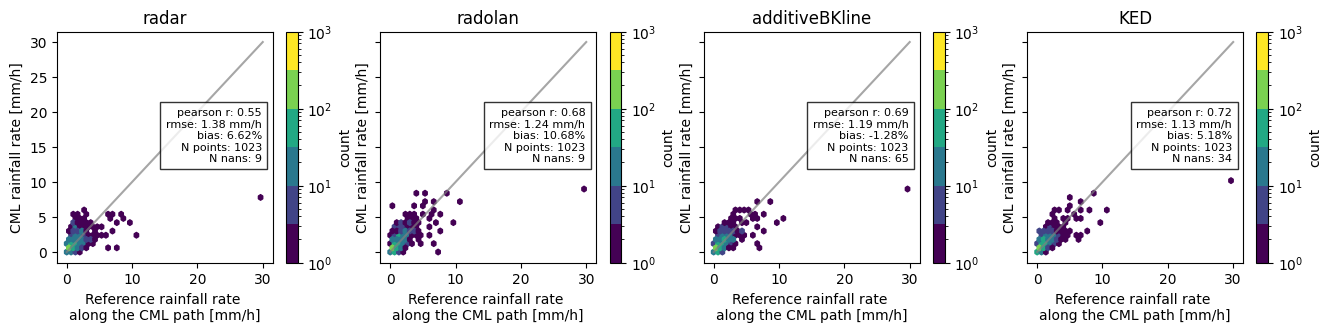

In [28]:
threshold = 0.1 # Values below this is ignored

# Specify rainfall fields to compare
rainfall_fields = [
    "rainfall_radar",
    "rainfall_radolan",
    "rainfall_additiveBKline",
    "rainfall_KED",
]

# Get fields at validation rain gauges
get_grid_at_points = plg.spatial.GridAtPoints(
    da_gridded_data=ds_rad.rainfall_radar, # Coordinates for all rainfall fields
    da_point_data=ds_gauges_test, # Coordinates for test rain gauges
    nnear=1,
    stat="best",
)

# Sample rainfall fields
for rainfall_field in rainfall_fields:
    ds_gauges_test[rainfall_field] = get_grid_at_points(
        da_gridded_data=ds_rad[rainfall_field],
        da_point_data=ds_gauges_test.rainfall_amount, # 
    )

# Rain gauges from test dataset considered ground truth
ground_truth = ds_gauges_test.rainfall_amount.to_numpy().flatten()

# Plot metrics and scatterplots
fig, ax = plt.subplots(1, len(rainfall_fields), figsize=(len(rainfall_fields)*4, 3), sharex=True, sharey=True)
for i, rainfall_field in enumerate(rainfall_fields):
    # Get predictions at test gauges
    predicted = ds_gauges_test[rainfall_field].to_numpy().flatten()
    
    rainfall_metrics = plg.validation.calculate_rainfall_metrics(
        reference=ground_truth,
        estimate=predicted,
        ref_thresh=threshold,
        est_thresh=threshold,
    )
    
    # plotting the scatter density plots
    hx = plg.validation.plot_hexbin(
        ground_truth,
        predicted,
        ref_thresh=threshold,
        est_thresh=threshold,
        ax=ax[i],
    )
    ax[i].set_title(rainfall_field.split("_")[1])
    
    # adding metrics to the plot for subplot 0
    plotted_metrics = (
        f"pearson r: {np.round(rainfall_metrics['pearson_correlation_coefficient'], 2)}\n"
        f"rmse: {np.round(rainfall_metrics['root_mean_square_error'], 2)} mm/h\n"
        f"bias: {np.round(rainfall_metrics['percent_bias'], 2)}%\n"
        f"N points: {rainfall_metrics['N_all']}\n"
        f"N nans: {rainfall_metrics['N_nan']}"
    )
    
    ax[i].text(
        0.95,
        0.55,
        plotted_metrics,
        fontsize=8,
        transform=ax[i].transAxes,
        verticalalignment="center",
        horizontalalignment="right",
        bbox={"facecolor": "white", "alpha": 0.8},
    )
